In [125]:
import numpy as np
from ecl.eclfile import EclFile
from ecl.eclfile import EclInitFile, EclRestartFile
from ecl.grid import EclGrid
from datetime import datetime  
from matplotlib.pyplot import show 
import matplotlib.pyplot as plt
#import rips 
import math
from os.path import exists
import os, sys
import pandas as pd
from matplotlib import rcParams
from matplotlib import font_manager
%matplotlib inline
import matplotlib.colors as colors
from matplotlib.patches import Rectangle

rcParams['figure.dpi'] = 200



font_path = r'Equinor_regular'

font_files = font_manager.findSystemFonts(fontpaths=font_path)

for font_file in font_files:
    font_manager.fontManager.addfont(font_file)



rcParams['font.family'] = 'Equinor'
rcParams['font.size'] = 9


In [126]:
pd.set_option('display.max_columns', None)

In [127]:
# where python codes located
# sys.path.append('../src')

# Load well CSV file

Process CSV with well class.
Predefine a dictionary that includes the input CSV well file, the simulation path, and the PFT sim case name

In [128]:
from well_class import *

#Import CSV tables
# filename = r'GaP_input_Wildcat_v3.csv'


# dir_set = [ well_csv, sim_path, sim_case ]

smeaheia_v1 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 'sim_path': r'/scratch/SCS/eim/SMEAHEIA', 'simcase': r'GEN_NOLGR_PH2', 'name': 'smeaheia_v1'}
smeaheia_v2 = {'well_input': r'GaP_input_Smeaheia_v3.csv', 'sim_path': r'/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model', 'simcase': r'TEMP-0', 'name': 'smeaheia_v2'}
wildcat = {'well_input': r'GaP_input_Wildcat_v3.csv', 'sim_path': r'/scratch/SCS/bkh/well_class_test1/realization-0/iter-0/pflotran/model', 'simcase': r'TEMP-0', 'name': 'wildcat'}

In [129]:
case = wildcat

# case = smeaheia_v1

# case = smeaheia_v2

In [130]:

# root_path = '/scratch/SCS/gpb/SCREEN/GaP_code'

root_path = f'../../test_data/examples/{case["name"]}'

well_name = os.path.join(root_path, case['well_input'])

In [131]:
well_csv = csv_parser(well_name)

#Process well by running well class
my_well = Well( header       = well_csv['well_header'], 
                drilling     = well_csv['drilling'],
                casings      = well_csv['casing_cement'],
                barriers     = well_csv['barriers'], 
                reservoir_P  = well_csv['reservoir_pressure'],
                main_barrier = well_csv['main_barrier'],
                barrier_perm = well_csv['barrier_permeability'],
                co2_datum    = well_csv['co2_datum'],
                geology      = well_csv['geology'],
           )

Hydrostatic pressure at reference depth 2238 is 218.89
RP1 set as hydrostatic P = 218.89 bar
RP2 is set as delta pressure, which yields P = 218.89 +20.00 = 238.89 bar
Reference depth: 2238
    0.01     10.00    1000.00
RP1       0  0.01894  1.90556
RP2       0  0.02714   2.7252


# Loading the model

- Load the PFT grid, init and restart files.
- Grid contains geometry specs
- INIT contains static properties (i.e. poro., perm., transmissibilities)
- RSR contains dynamic properties (i.e. saturations, pressure)


In [132]:
# simulation case without legacy well 

# path = '/scratch/SCS/bkh/wbook/realization-0/iter-0/pflotran/model'

# location of .egrid
simcase = os.path.join(case['sim_path'], case['simcase'])

#Get grid dimensions and coordinates
grid = EclGrid(simcase + ".EGRID") 
#init = EclGrid(simcase + ".INIT") 
init = EclInitFile(grid, simcase + ".INIT")
# restart file
rst = EclRestartFile(grid, simcase + ".UNRST")

Store INIT parameters into a Pandas Dataframe

In [133]:
grid_init = grid.export_index()

# Static properties Dataframe
for key in init.keys():
        try:
                grid_init[key] = init[key][0].numpy_view()
        except:
                continue

#Create coordinate X, Y, Z

xcoord = (grid_init.query("j==0&k==0").DX.cumsum() - grid_init.query("j==0&k==0").DX/2).values
ycoord = (grid_init.query("i==0&k==0").DY.cumsum() - grid_init.query("i==0&k==0").DY/2).values
zcoord = (grid_init.query("i==0&j==0").DZ.cumsum() - grid_init.query("i==0&j==0").DZ/2).values

xcorn  = (grid_init.query("j==0&k==0").DX.cumsum()).values
ycorn  = (grid_init.query("i==0&k==0").DY.cumsum()).values
zcorn  = (grid_init.query("i==0&j==0").DZ.cumsum()).values

xcorn = np.append(0, xcorn)
ycorn = np.append(0, ycorn)
zcorn = np.append(0, zcorn)

mid_j = grid_init.j.max()//2
mid_i = grid_init.i.max()//2

xcorn -= xcoord[mid_i]
ycorn -= ycoord[mid_j]


map_X = dict(zip(grid_init.query("j==0&k==0")['i'], xcoord))
map_Y = dict(zip(grid_init.query("i==0&k==0")['j'], ycoord))
map_Z = dict(zip(grid_init.query("i==0&j==0")['k'], zcoord))


grid_init['X'] = grid_init['i'].map(map_X)
grid_init['Y'] = grid_init['j'].map(map_Y)
grid_init['Z'] = grid_init['k'].map(map_Z)


In [134]:
grid_init.tail()

,i,j,k,active,PORV,DX,DY,DZ,PERMX,PERMY,PERMZ,MULTX,MULTY,MULTZ,MULTX-,MULTY-,MULTZ-,TRANX,TRANY,TRANZ,PORO,DEPTH,NTG,SATNUM,X,Y,Z
23995,15,19,59,23995,40000.0,200.0,200.0,5.0,0.01,0.01,0.001,1.0,1.0,1.0,1.0,1.0,1.0,0.000426,0.0,0.0,0.2,2483.5,1.0,1,3100.0,3900.0,2479.5
23996,16,19,59,23996,40000.0,200.0,200.0,5.0,0.01,0.01,0.001,1.0,1.0,1.0,1.0,1.0,1.0,0.000426,0.0,0.0,0.2,2483.5,1.0,1,3300.0,3900.0,2479.5
23997,17,19,59,23997,40000.0,200.0,200.0,5.0,0.01,0.01,0.001,1.0,1.0,1.0,1.0,1.0,1.0,0.000426,0.0,0.0,0.2,2483.5,1.0,1,3500.0,3900.0,2479.5
23998,18,19,59,23998,40000.0,200.0,200.0,5.0,0.01,0.01,0.001,1.0,1.0,1.0,1.0,1.0,1.0,0.000426,0.0,0.0,0.2,2483.5,1.0,1,3700.0,3900.0,2479.5
23999,19,19,59,23999,40000.0,200.0,200.0,5.0,0.01,0.01,0.001,1.0,1.0,1.0,1.0,1.0,1.0,0.000000,0.0,0.0,0.2,2483.5,1.0,1,3900.0,3900.0,2479.5


Plot well sketch and 2D slice of the coarse gride permeability, side by side.

In [135]:
# Z.min()

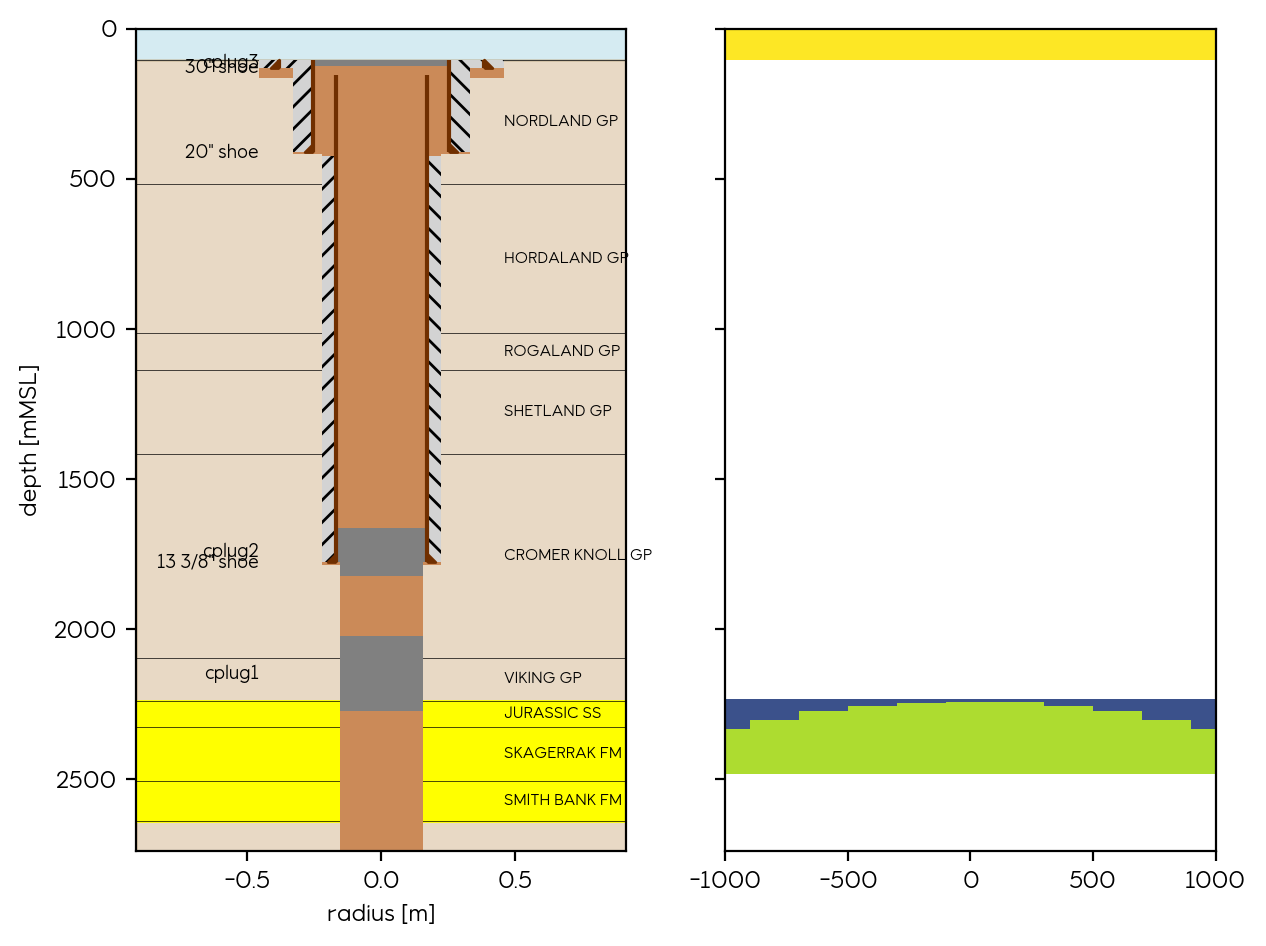

In [136]:


fig, (ax2, ax) = plt.subplots(1,2, sharey=True)

nx, ny, nz, total = grid.get_dims()

# nx = 1


XZ_slice = grid_init.query('j==@mid_j')

x = xcorn
y = zcorn
Z = XZ_slice.PERMX.values.reshape(nz, nx)

# ax.pcolor(Z,  norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))
zmin = Z.min()
zmax = Z.max()
if zmin == 0:
        zmin = 1e-4

ax.pcolormesh(x, y, Z,  norm=colors.LogNorm(vmin=zmin, vmax=zmax))

my_well.plot_sketch(ax2)

ax.set_xlim(-1e3, 1e3)


fig.tight_layout(h_pad = 0)

In [137]:
# Retrieve coarse grid indexes where LGR will be placed
main_grd_i     = grid_init.j.max()//2
main_grd_j     = grid_init.i.max()//2

# Rettrieve min and max k-index for column where LGR will be placed
main_grd_min_k = grid_init.k.min()
main_grd_max_k = grid_init.k.max()

#Retrieve coarse cell sizes
main_grd_dx = grid_init.query('i==@main_grd_i & j == @main_grd_j & k==k.min()')['DX'].iloc[0]
main_grd_dy = grid_init.query('i==@main_grd_i & j == @main_grd_j & k==k.min()')['DY'].iloc[0]


#Retrieve number of cells representing water column and overburden
no_of_layers_in_OB    = grid_init.query('i==@main_grd_i & j == @main_grd_j & DZ >  10')['DZ'].shape[0]
no_of_layers_below_OB = grid_init.query('i==@main_grd_i & j == @main_grd_j & DZ <= 10')['DZ'].shape[0]



# LRG name 
LGR_NAME = 'LEG_HIRES'



# Permeability of the tube and cement  
pipe_perm = 10000
cement_perm = 5 


# Compute annulus thickness. 
# For simplicty it assumes annulus between casing and openhole as entire annulus

casings_df = pd.DataFrame(my_well.casings)
drilling_df = pd.DataFrame(my_well.drilling)
borehole_df = pd.DataFrame(my_well.borehole)
barriers_df = pd.DataFrame(my_well.barriers)


casings_df['ann_od_m'] = np.nan
casings_df['ann_bottom_msl'] = np.nan


for idx, row in casings_df[::-1].iterrows():
        d, top, bottom = row[['diameter_m', 'top_msl', 'bottom_msl']]

        hole = drilling_df[drilling_df['diameter_m'] > d].iloc[-1]
        hole_top, hole_bottom, hole_d = hole[['top_msl', 'bottom_msl', 'diameter_m']]

        casings_df.loc[idx, 'ann_od_m'] = hole_d
        casings_df.loc[idx, 'ann_bottom_msl'] = hole_bottom

#Compute inner area
casings_df['A_i'] = np.pi * (casings_df['diameter_m']/2)**2

#Compute outer area
casings_df['A_o'] = np.pi * (casings_df['ann_od_m']/2)**2


casings_df['thick_m'] = (casings_df['ann_od_m'] - casings_df['diameter_m'])/2

min_grd_size = casings_df['thick_m'].min()

if min_grd_size < 0.05:
    min_grd_size = 0.05

print(f'Minimimum grid size is {min_grd_size*100:.2f} cm')



#Compute number of cells representing borehole


def compute_ngrd(diam, min_grd_size):
    """Takes diameter in m and min grid size.
    Computes floor and cealing of discretizing diameter.
    Returns the discretization with smallest discrepancy
    """
    area = np.pi * (diam/2)**2
    cart_radius = np.sqrt(area) / 2

    ceil_nx =  2*int(np.ceil(cart_radius/ min_grd_size))
    floor_nx = 2*int(np.floor(cart_radius / min_grd_size))
                
    ceil_diff = np.abs(area - (ceil_nx*min_grd_size)**2)
    floor_diff = np.abs(area -(floor_nx*min_grd_size)**2)

    if floor_diff < ceil_diff:
        n_grd = floor_nx
    else:
        n_grd = ceil_nx

    return n_grd


# Compute diameters in LGR cell sizes
borehole_df['n_grd_id'] = borehole_df['id_m'].map(lambda x: compute_ngrd(x, min_grd_size))
drilling_df['n_grd_id']  = drilling_df['diameter_m'].map(lambda x: compute_ngrd(x, min_grd_size))
casings_df[ 'n_grd_id']  = casings_df['diameter_m'].map(lambda x: compute_ngrd(x, min_grd_size))

#Number of cells representing horizontal LGR
no_latral_fine_grd = drilling_df['n_grd_id'].max()


LGR_size_fine_grd = [min_grd_size]*no_latral_fine_grd

#Number of logarithmic increments between smallest mesh and coarse mesh
n_log_inc = 3

#Distance between cells representing the wells and coarse cells
DX_transition = (main_grd_dx - (no_latral_fine_grd*min_grd_size)) / 2
DY_transition = (main_grd_dy - (no_latral_fine_grd*min_grd_size)) / 2

#Compute corner edges of logarithmic increments
Xcorn_log_inc = np.logspace(np.log10(min_grd_size), np.log10(DX_transition + min_grd_size), num=n_log_inc+1) 
Ycorn_log_inc = np.logspace(np.log10(min_grd_size), np.log10(DY_transition + min_grd_size), num=n_log_inc+1) 


#Compute DX DY of log increments
DX_log_inc = np.diff(Xcorn_log_inc)
DY_log_inc = np.diff(Ycorn_log_inc)

#Create dx, dy
LGR_sizes_x = np.concatenate((DX_log_inc[::-1], [min_grd_size] * no_latral_fine_grd, DX_log_inc))
LGR_sizes_y = np.concatenate((DY_log_inc[::-1], [min_grd_size] * no_latral_fine_grd, DY_log_inc))



#Retrieve DZ in coarse grid
main_DZ = grid_init.query('i==@main_grd_i & j == @main_grd_j')['DZ'].values
DZ_ovb_coarse = grid_init.query('i==@main_grd_i & j == @main_grd_j & DZ > 10')['DZ'].values

DZ_ovb = np.repeat(DZ_ovb_coarse/10, 10)
DZ_rsrv = grid_init.query('i==@main_grd_i & j == @main_grd_j & DZ <= 10')['DZ'].values

LGR_sizes_z = np.concatenate((DZ_ovb, DZ_rsrv))
Zcorn_LGR = np.append(0, LGR_sizes_z.cumsum())


#grid refinement in k direction
LGR_num_z = len(LGR_sizes_z)

#LGR dimensions
nx = len(LGR_sizes_x)
ny = len(LGR_sizes_y)
nz = LGR_num_z

total_dim = nx * ny * nz

#Create i, j, k indices
cell_ijk = np.indices((nx, ny, nz))
cell_ijk = cell_ijk.reshape((3,total_dim)).T

#Create LGR Dataframe with indices
mesh_df = pd.DataFrame(data = cell_ijk, columns = ['i', 'j', 'k'])
mesh_df.sort_values(by=['k', 'i'], inplace = True)
mesh_df.reset_index(inplace=True, drop=True)

#Creat DX, DY, DZ
DX_grid, DZ_grid, DY_grid = np.meshgrid(LGR_sizes_x, LGR_sizes_z, LGR_sizes_y)

mesh_df['DX'] = DX_grid.flatten()
mesh_df['DY'] = DY_grid.flatten()
mesh_df['DZ'] = DZ_grid.flatten()

#Create coordinate X, Y, Z

xcoord = (mesh_df.query("j==0&k==0").DX.cumsum() - mesh_df.query("j==0&k==0").DX/2).values
ycoord = (mesh_df.query("i==0&k==0").DY.cumsum() - mesh_df.query("i==0&k==0").DY/2).values
zcoord = (mesh_df.query("i==0&j==0").DZ.cumsum() - mesh_df.query("i==0&j==0").DZ/2).values


map_X = dict(zip(mesh_df.query("j==0&j==0")['i'], xcoord))
map_Y = dict(zip(mesh_df.query("i==0&k==0")['j'], ycoord))
map_Z = dict(zip(mesh_df.query("i==0&j==0")['k'], zcoord))


mesh_df['X'] = mesh_df['i'].map(map_X)
mesh_df['Y'] = mesh_df['j'].map(map_Y)
mesh_df['Z'] = mesh_df['k'].map(map_Z)


Minimimum grid size is 5.24 cm


In [138]:
mesh_df.tail()

,i,j,k,DX,DY,DZ,X,Y,Z
72595,21,17,149,91.591631,0.052388,5.0,154.204185,100.340519,2479.501953
72596,21,18,149,91.591631,0.052388,5.0,154.204185,100.392906,2479.501953
72597,21,19,149,91.591631,0.596675,5.0,154.204185,100.717438,2479.501953
72598,21,20,149,91.591631,7.392594,5.0,154.204185,104.712072,2479.501953
72599,21,21,149,91.591631,91.591631,5.0,154.204185,154.204185,2479.501953


In [139]:
xcorn  = (mesh_df.query("j==0&k==0").DX.cumsum()).values
ycorn  = (mesh_df.query("i==0&k==0").DY.cumsum()).values
zcorn  = (mesh_df.query("i==0&j==0").DZ.cumsum()).values

xcorn = np.append(0, xcorn)
ycorn = np.append(0, ycorn)
zcorn = np.append(0, zcorn)

mid_j = mesh_df.j.max()//2
mid_i = mesh_df.i.max()//2

xcorn -= main_grd_dx/2
ycorn -= main_grd_dy/2



In [140]:

#Upscale coarse properties

fields = ['PORV', 'PERMX', 'PERMY', 'PERMZ', 'MULTX', 'MULTY',
       'MULTZ', 'MULTX-', 'MULTY-', 'MULTZ-', 'PORO']

for field in fields:
    mesh_df[field] = np.nan

for idx, row in grid_init.query('i==@mid_i &j==@mid_j').iterrows():
    top  = row.Z - row.DZ/2
    base = row.Z + row.DZ/2

    for field in fields:

        mesh_df.loc[(mesh_df['Z']>=top) & (mesh_df['Z']<base), field] = row[field]


#Corner Z points for each cell
mesh_df['Zcorn_top'] = mesh_df['Z'] - mesh_df['DZ']/2
mesh_df['Zcorn_bottom'] = mesh_df['Z'] + mesh_df['DZ']/2

mesh_df['material'] = 'overbuden'



def get_k_indices(df, top, bottom):
        """
        Takes the mesh data frame and a value of top and bottom depth interval.
        Returns the min and max k indexes
        """
        if top <= df['Zcorn_top'].min():
                k_min = df['k'].min()
        elif top in df['Zcorn_top'].values:

                k_min = df.query('Zcorn_top==@top & Zcorn_bottom>=@top')['k'].iloc[0]
        else:
                k_min = df.query('Zcorn_top<=@top & Zcorn_bottom>=@top')['k'].iloc[0]

        if bottom >= df['Zcorn_bottom'].max():
                k_max = df['k'].max()

        elif bottom in df['Zcorn_bottom'].values:
                print(bottom)
                k_max = df.query('Zcorn_top<=@bottom & Zcorn_bottom==@bottom')['k'].iloc[0]
        else:
                k_max = df.query('Zcorn_top<=@bottom & Zcorn_bottom>=@bottom')['k'].iloc[0]


        return k_min, k_max

In [141]:
mid_df = grid_init.query('i==@mid_i & j==@mid_j')
mid_df.tail()

,i,j,k,active,PORV,DX,DY,DZ,PERMX,PERMY,PERMZ,MULTX,MULTY,MULTZ,MULTX-,MULTY-,MULTZ-,TRANX,TRANY,TRANZ,PORO,DEPTH,NTG,SATNUM,X,Y,Z
22210,10,10,55,22210,40000.0,200.0,200.0,5.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,42.635082,42.635082,6821.613281,0.2,2463.5,1.0,1,2100.0,2100.0,2459.5
22610,10,10,56,22610,40000.0,200.0,200.0,5.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,42.635082,42.635082,6821.613281,0.2,2468.5,1.0,1,2100.0,2100.0,2464.5
23010,10,10,57,23010,40000.0,200.0,200.0,5.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,42.635082,42.635082,6821.613281,0.2,2473.5,1.0,1,2100.0,2100.0,2469.5
23410,10,10,58,23410,40000.0,200.0,200.0,5.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,42.635082,42.635082,6821.613281,0.2,2478.5,1.0,1,2100.0,2100.0,2474.5
23810,10,10,59,23810,40000.0,200.0,200.0,5.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,42.635082,42.635082,0.000000,0.2,2483.5,1.0,1,2100.0,2100.0,2479.5


In [142]:
mesh_df.tail()

,i,j,k,DX,DY,DZ,X,Y,Z,PORV,PERMX,PERMY,PERMZ,MULTX,MULTY,MULTZ,MULTX-,MULTY-,MULTZ-,PORO,Zcorn_top,Zcorn_bottom,material
72595,21,17,149,91.591631,0.052388,5.0,154.204185,100.340519,2479.501953,40000.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,2477.001953,2482.001953,overbuden
72596,21,18,149,91.591631,0.052388,5.0,154.204185,100.392906,2479.501953,40000.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,2477.001953,2482.001953,overbuden
72597,21,19,149,91.591631,0.596675,5.0,154.204185,100.717438,2479.501953,40000.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,2477.001953,2482.001953,overbuden
72598,21,20,149,91.591631,7.392594,5.0,154.204185,104.712072,2479.501953,40000.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,2477.001953,2482.001953,overbuden
72599,21,21,149,91.591631,91.591631,5.0,154.204185,154.204185,2479.501953,40000.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,2477.001953,2482.001953,overbuden


## Assign open hole/open pipe cells in mesh

In [143]:
mesh_df.tail()

,i,j,k,DX,DY,DZ,X,Y,Z,PORV,PERMX,PERMY,PERMZ,MULTX,MULTY,MULTZ,MULTX-,MULTY-,MULTZ-,PORO,Zcorn_top,Zcorn_bottom,material
72595,21,17,149,91.591631,0.052388,5.0,154.204185,100.340519,2479.501953,40000.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,2477.001953,2482.001953,overbuden
72596,21,18,149,91.591631,0.052388,5.0,154.204185,100.392906,2479.501953,40000.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,2477.001953,2482.001953,overbuden
72597,21,19,149,91.591631,0.596675,5.0,154.204185,100.717438,2479.501953,40000.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,2477.001953,2482.001953,overbuden
72598,21,20,149,91.591631,7.392594,5.0,154.204185,104.712072,2479.501953,40000.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,2477.001953,2482.001953,overbuden
72599,21,21,149,91.591631,91.591631,5.0,154.204185,154.204185,2479.501953,40000.0,1000.0,1000.0,100.0,1.0,1.0,1.0,1.0,1.0,1.0,0.2,2477.001953,2482.001953,overbuden


In [144]:
oh_perm = 1e5

for idx, row in drilling_df.iterrows():
    top = row['top_msl']
    bottom = row['bottom_msl']

    if top < mesh_df['Zcorn_bottom'].max():
        k_min, k_max = get_k_indices(mesh_df, top, bottom)




        n_grd = row['n_grd_id']

        ij_min = (nx-n_grd)//2
        ij_max = ij_min + n_grd - 1

        criteria =  '(k >= @k_min) & (k <= @k_max) & (i>=@ij_min) & (i<=@ij_max) & (j>=@ij_min) & (j<=@ij_max)'

        mesh_df.loc[mesh_df.eval(criteria), 'material'] = 'openhole'




barriers_df['k_min'] = np.nan
barriers_df['k_max'] = np.nan

for idx, row in barriers_df.iterrows():
    k_min, k_max = get_k_indices(mesh_df, row.top_msl, row.bottom_msl)
    barriers_df.loc[idx, 'k_min'] = k_min
    barriers_df.loc[idx, 'k_max'] = k_max


ij_ext_min = mesh_df['i'].min()
ij_ext_max = mesh_df['i'].max()

for idx, row in casings_df.iterrows():
    top = row['top_msl']
    bottom = row['bottom_msl']

    toc = row['toc_msl']
    boc = row['boc_msl']
    
    k_min, k_max = get_k_indices(mesh_df, top, bottom)

    toc_k_min, toc_k_max = get_k_indices(mesh_df, toc, boc)
    n_grd = row['n_grd_id']

    ij_min = (nx-n_grd)//2
    ij_max = ij_min + n_grd - 1

    txt = f'PERMX  {oh_perm:.0f}  {ij_min+1}  {ij_max+1}  {ij_min+1}  {ij_max+1}   {k_min+1}  {k_max+1}   /'
    print(txt)
    # print(toc_k_min, toc_k_max, ij_min, ij_max)
    print(toc, boc, toc_k_min, toc_k_max)

    criteria_i =  '(material == "openhole") & (k >= @k_min) & (k <= @k_max) & ((i<@ij_min) | (i>@ij_max))'
    criteria_j =  '(material == "openhole") & (k >= @k_min) & (k <= @k_max) & ((j<@ij_min) | (j>@ij_max))'

    mesh_df.loc[mesh_df.eval(criteria_i), 'material'] = 'annulus'
    mesh_df.loc[mesh_df.eval(criteria_j), 'material'] = 'annulus'

    criteria = '(material == "annulus") & (k >= @toc_k_min) & (k <= @toc_k_max)'  
    mesh_df.loc[mesh_df.eval(criteria), 'material'] = 'cement_bond'

    criteria = '(material == "annulus")'  
    mesh_df.loc[mesh_df.eval(criteria), 'material'] = 'openhole'
    # mesh_df.loc[mesh_df.eval(criteria_j), 'material'] = 'cementbond'   





for idx, row in barriers_df.iterrows():
    b_k_min, b_k_max = get_k_indices(mesh_df, row.top_msl, row.bottom_msl)

    criteria = '(material == "openhole") & (k >= @b_k_min) & (k <= @b_k_max)' 
    mesh_df.loc[mesh_df.eval(criteria), 'material'] = 'barrier'





criteria = 'material == "openhole"'
mesh_df.loc[mesh_df.eval(criteria), 'PERMX'] = oh_perm

criteria = 'material == "cement_bond"'
mesh_df.loc[mesh_df.eval(criteria), 'PERMX'] = .5


criteria = 'material == "barrier"'
mesh_df.loc[mesh_df.eval(criteria), 'PERMX'] = .5

PERMX  100000  6  17  6  17   11  12   /
105.0 131.0 10 11
PERMX  100000  8  15  8  15   11  27   /
105.0 412.0 10 26
PERMX  100000  9  14  9  14   14  82   /
423.0 1776.0 27 81


In [145]:
casings_df

,top_rkb,bottom_rkb,diameter_in,toc_rkb,boc_rkb,shoe,diameter_m,top_msl,bottom_msl,toc_msl,boc_msl,ann_od_m,ann_bottom_msl,A_i,A_o,thick_m,n_grd_id
0,132,158,30.000,132,158,True,0.762000,105.0,131.0,105.0,131.0,0.9144,163.0,0.456037,0.656693,0.076200,12
1,132,439,20.000,132,439,True,0.508000,105.0,412.0,105.0,412.0,0.6604,417.0,0.202683,0.342534,0.076200,8
2,182,1803,13.375,450,1803,True,0.339725,155.0,1776.0,423.0,1776.0,0.4445,1785.0,0.090645,0.155179,0.052388,6


In [146]:
barriers_df

,barrier_name,barrier_type,top_rkb,bottom_rkb,top_msl,bottom_msl,k_min,k_max
0,cplug3,cplug,132,150,105.0,123.0,10.0,11.0
1,cplug2,cplug,1690,1850,1663.0,1823.0,77.0,83.0
2,cplug1,cplug,2050,2300,2023.0,2273.0,91.0,108.0


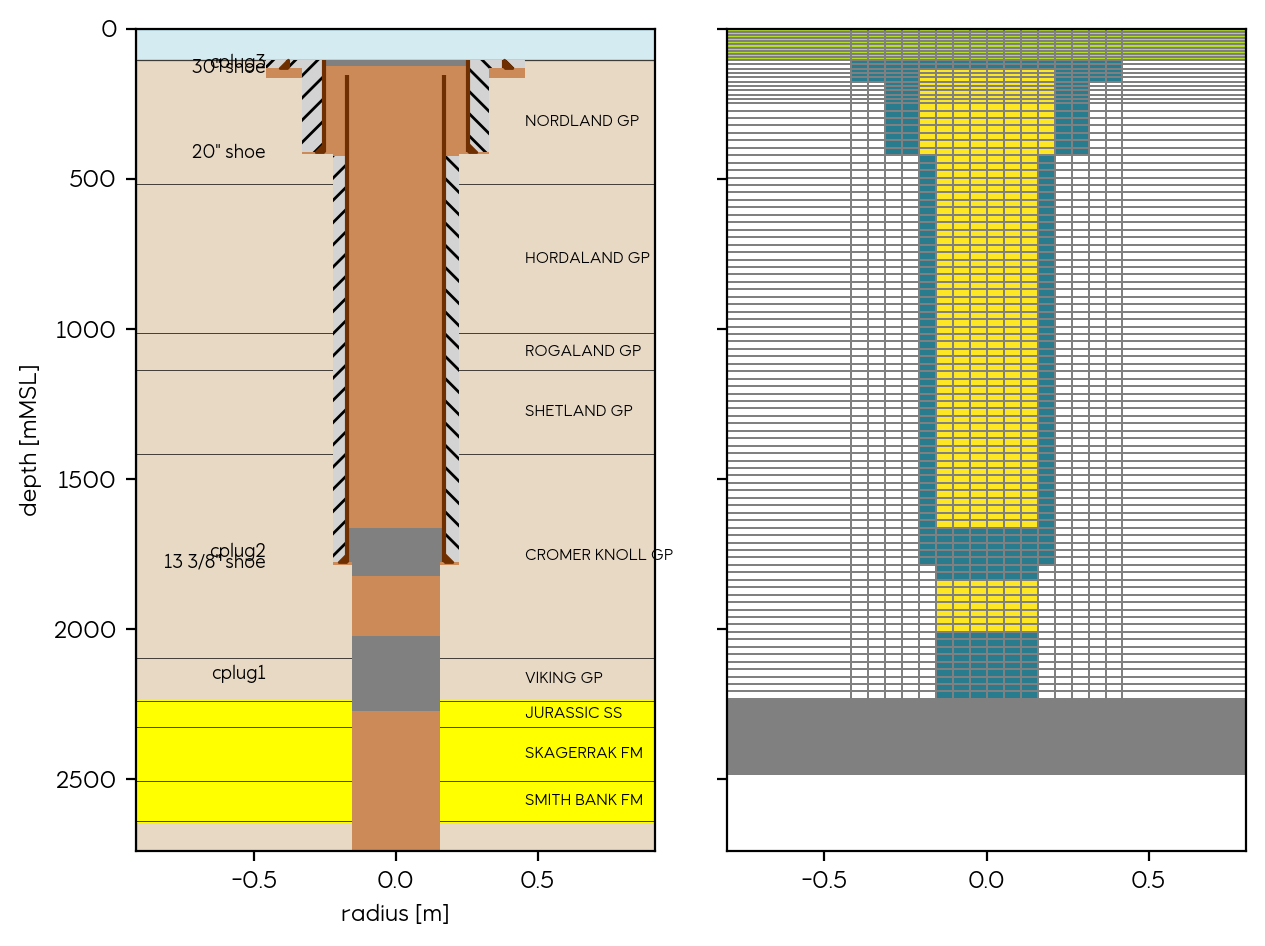

In [147]:


fig, (ax2, ax) = plt.subplots(1,2, sharey=True)

# nx = 1


XZ_slice = mesh_df.query('j==@mid_i')

x = xcorn
y = zcorn
Z = XZ_slice.PERMX.values.reshape(nz, nx)

zmin = Z.min()
zmax = Z.max()
if zmin == 0:
        zmin = 1e-4

# ax.pcolor(Z,  norm=colors.LogNorm(vmin=Z.min(), vmax=Z.max()))
ax.pcolormesh(x, y, Z,  norm=colors.LogNorm(vmin=zmin, vmax=zmax), edgecolor='gray', lw = 0.01)

# for idx, row in drilling_df.iterrows():
#         xy = (-row['cart_dist']/2, row['top_msl'])
#         width = row['cart_dist']
#         height = row['bottom_msl'] - row['top_msl']
#         ax.add_patch(Rectangle(xy, width, height, zorder=10, facecolor=r'#CB8A58', alpha=0.5))


# #Draw casings
# ax.vlines(x= casings_df['cart_dist']/2, ymin=casings_df['top_msl'], ymax=casings_df['bottom_msl'],  color='k', lw=1.5, zorder=10)
# ax.vlines(x=-casings_df['cart_dist']/2, ymin=casings_df['top_msl'], ymax=casings_df['bottom_msl'],  color='k', lw=1.5, zorder=10)

my_well.plot_sketch(ax2)


ax.set_xlim(-.8, .8)
# ax.set_ylim(710, 670)

fig.tight_layout(h_pad = 0)


# Write LGR file

In [148]:


import io



file_path = 'test_output.txt'

output_io = io.StringIO()

#PRE-CARFIN, isolates OVB from reservoir 
print ('Prints CARFIN Keywords in',LGR_NAME,'.grdecl file')
output_io.write('--isolating OVB from reservoir\n')
output_io.write('EQUALS\n') 
output_io.write(f'MULTX  0  1  {grid.getNX()}  1  {grid.getNY()}  {no_of_layers_in_OB+1} {no_of_layers_in_OB+1} /\n')
output_io.write(f'MULTY  0  1  {grid.getNX()}  1  {grid.getNY()}  {no_of_layers_in_OB+1} {no_of_layers_in_OB+1} /\n')
output_io.write(f'MULTZ  0  1  {grid.getNX()}  1  {grid.getNY()}  {no_of_layers_in_OB+1} {no_of_layers_in_OB+1} /\n')
output_io.write(f'MULTX  1  {1+main_grd_i} {1+main_grd_i}  {1+main_grd_j} {1+main_grd_j}  {no_of_layers_in_OB+1} {no_of_layers_in_OB+1} /\n')
output_io.write(f'MULTY  1  {1+main_grd_i} {1+main_grd_i}  {1+main_grd_j} {1+main_grd_j}  {no_of_layers_in_OB+1} {no_of_layers_in_OB+1} /\n')
output_io.write(f'MULTZ  1  {1+main_grd_i} {1+main_grd_i}  {1+main_grd_j} {1+main_grd_j}  {no_of_layers_in_OB+1} {no_of_layers_in_OB+1} /\n/\n\n')



# prints CARFIN KEYWORD in Eclipse 
print ('Prints CARFIN Keywords in',LGR_NAME,'.grdecl file')
output_io.write('CARFIN\n')
output_io.write(f'{LGR_NAME} {1+main_grd_i} {1+main_grd_i} {1+main_grd_j} {1+main_grd_j} {main_grd_min_k+1} {main_grd_max_k+1} {len(LGR_sizes_x)} {len(LGR_sizes_y)} {sum(LGR_num_z)} /\n\n')

output_io.write(f'NXFIN\n{len(LGR_sizes_x)} /\n\n')
output_io.write(f'NYFIN\n{len(LGR_sizes_y)} /\n\n')
output_io.write(f'NZFIN\n')
output_io.write(' '.join(map(str, LGR_num_z))+' /\n\n')

output_io.write(f'HXFIN\n')
output_io.write(" ".join(map("{:.1f}".format, LGR_sizes_x/LGR_sizes_x.min()))+' /\n\n')

output_io.write(f'HYFIN\n')
output_io.write(" ".join(map("{:.1f}".format, LGR_sizes_y/LGR_sizes_y.min()))+' /\n\n')


# Get the string content from the StringIO instance
output_txt = output_io.getvalue()

# Save the string content to an ASCII file
# file_path = "output.csv"
with open(file_path, "w", encoding='utf-8-sig') as file:
        file.write(output_txt)

# Close the StringIO instance
output_io.close()



Prints CARFIN Keywords in LEG_HIRES .grdecl file
Prints CARFIN Keywords in LEG_HIRES .grdecl file


TypeError: 'int' object is not iterable